# First Look

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [11]:
import gc

In [2]:
import os
os.listdir("./data/")

['all (1).zip',
 'Data_Dictionary.xlsx',
 'historical_transactions.csv',
 'merchants.csv',
 'new_merchant_transactions.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 '~$Data_Dictionary.xlsx']

# train & test

train.shape (201917, 6)
head
  first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            2016-08  C_ID_d639edf6cd          2          2          0   
3            2017-09  C_ID_186d6a6901          4          3          0   
4            2017-11  C_ID_cdbd2c0db2          1          3          0   

     target  
0 -0.820283  
1  0.392913  
2  0.688056  
3  0.142495  
4 -0.159749  
describe
count                  201917
unique                     75
top       2017-09-01 00:00:00
freq                    13878
first     2011-11-01 00:00:00
last      2018-02-01 00:00:00
Name: first_active_month, dtype: object


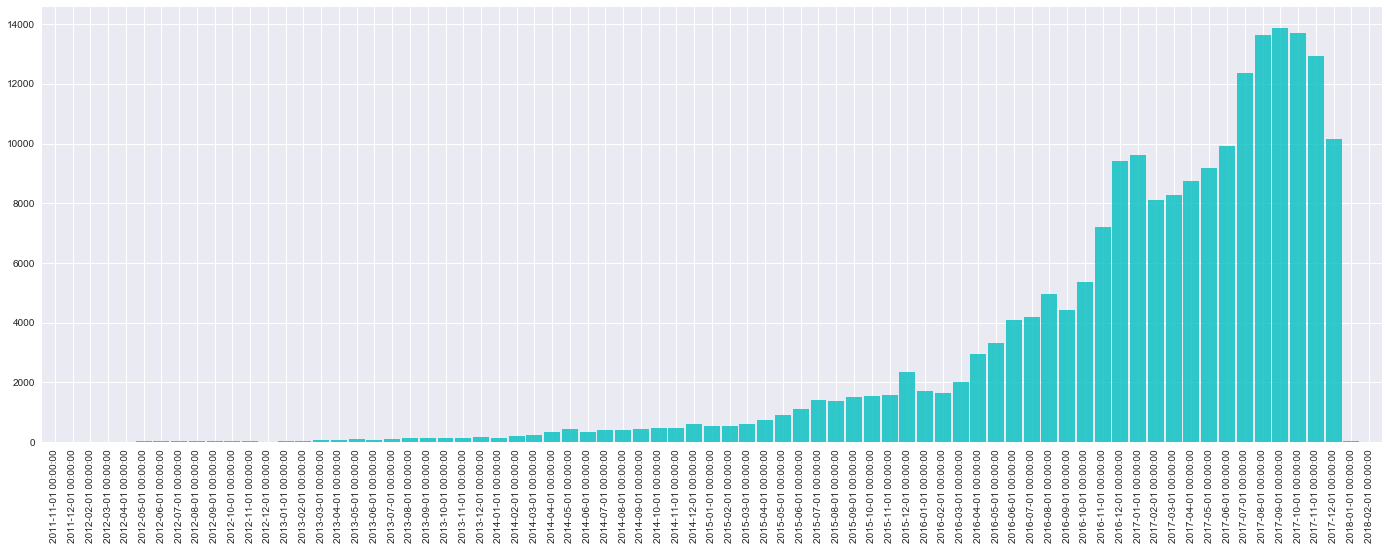

              count  mean   std    min   25%   50%   75%    max
feature_1  201917.0  3.11  1.19   1.00  2.00  3.00  4.00   5.00
feature_2  201917.0  1.75  0.75   1.00  1.00  2.00  2.00   3.00
feature_3  201917.0  0.57  0.50   0.00  0.00  1.00  1.00   1.00
target     201917.0 -0.39  3.85 -33.22 -0.88 -0.02  0.77  17.97
nunique
first_active_month        75
card_id               201917
feature_1                  5
feature_2                  3
feature_3                  2
target                197110
dtype: int64


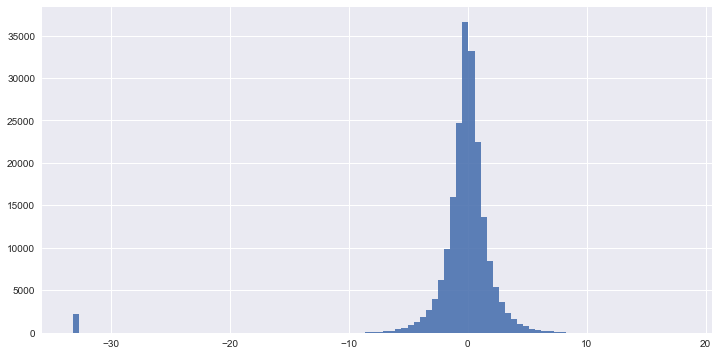

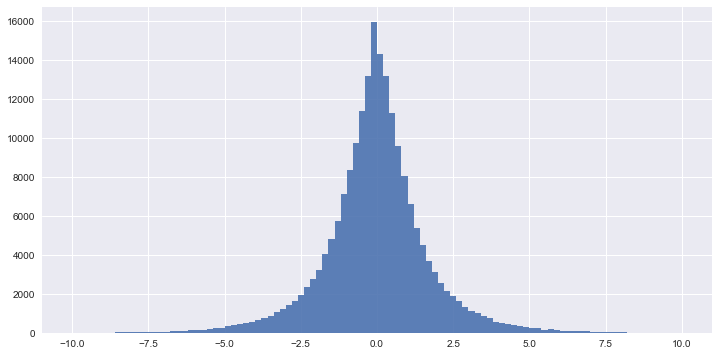

In [3]:
train = pd.read_csv("./data/train.csv")
print("train.shape", train.shape)
print("head")
print(train.head())
print("describe")
train["first_active_month"] = pd.to_datetime(train.first_active_month)
print(train.first_active_month.describe())
train.first_active_month.value_counts().sort_index().plot(kind="bar", figsize=(24, 8), color="c", width=.9, alpha=.8)
plt.show()
print(train.describe().T.apply(lambda x: round(x, 2)))
print("nunique")
print(train.nunique())
train.target.hist(bins=100, figsize=(12, 6), alpha=.9)
plt.show()
train[(train.target > -10) & (train.target < 10)].target.hist(bins=100, figsize=(12, 6), alpha=.9)
plt.show()

test.shape (123623, 5)
head
  first_active_month          card_id  feature_1  feature_2  feature_3
0            2017-04  C_ID_0ab67a22ab          3          3          1
1            2017-01  C_ID_130fd0cbdd          2          3          0
2            2017-08  C_ID_b709037bc5          5          1          1
3            2017-12  C_ID_d27d835a9f          2          1          0
4            2015-12  C_ID_2b5e3df5c2          5          1          1
describe
count                  123622
unique                     75
top       2017-09-01 00:00:00
freq                     8805
first     2011-11-01 00:00:00
last      2018-01-01 00:00:00
Name: first_active_month, dtype: object
Axes(0.125,0.125;0.775x0.755)
              count  mean   std  min  25%  50%  75%  max
feature_1  123623.0  3.11  1.19  1.0  2.0  3.0  4.0  5.0
feature_2  123623.0  1.74  0.75  1.0  1.0  2.0  2.0  3.0
feature_3  123623.0  0.56  0.50  0.0  0.0  1.0  1.0  1.0
nunique
first_active_month        75
card_id               

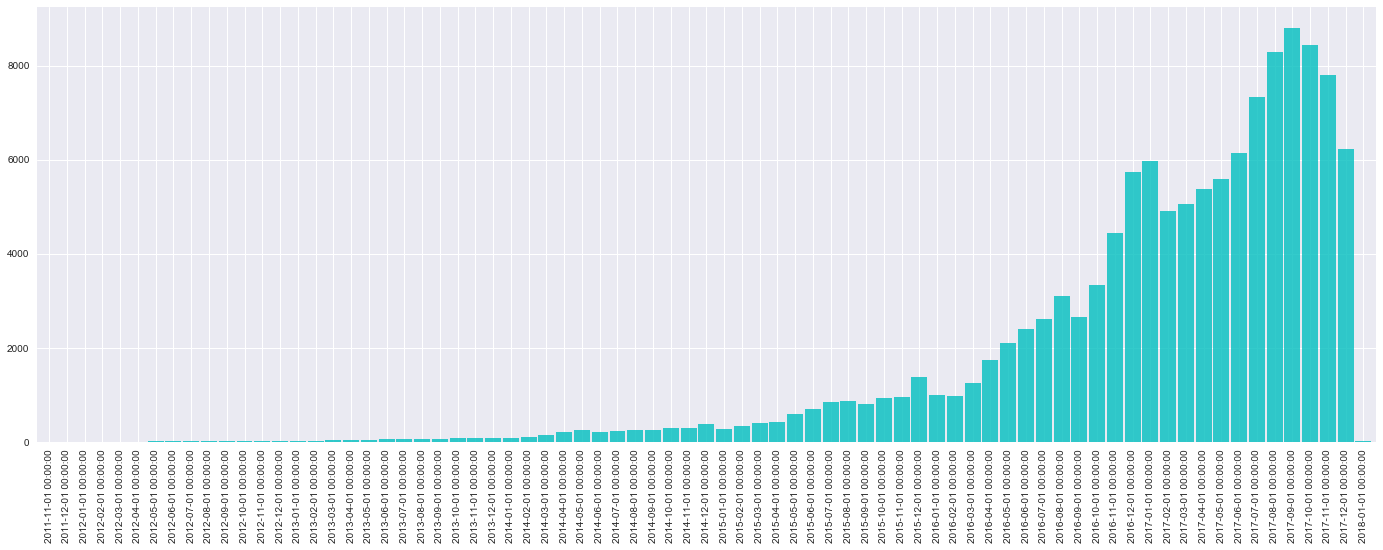

In [4]:
test = pd.read_csv("./data/test.csv")
print("test.shape", test.shape)
print("head")
print(test.head())
print("describe")
test["first_active_month"] = pd.to_datetime(test.first_active_month)
print(test.first_active_month.describe())
print(test.first_active_month.value_counts().sort_index().plot(kind="bar", figsize=(24, 8), color="c", width=.9, alpha=.8))
print(test.describe().T.apply(lambda x: round(x, 2)))
print("nunique")
print(test.nunique())

In [12]:
del train, test
gc.collect()

44

# historical_transactions & new_merchant_transactions

In [5]:
historical_transactions = pd.read_csv("./data/historical_transactions.csv")
print("historical_transactions.shape", historical_transactions.shape)
print("head")
print(historical_transactions.head())
print("describe")
historical_transactions["purchase_date"] = pd.to_datetime(historical_transactions.purchase_date)
print(historical_transactions.purchase_date.describe())

historical_transactions.shape (29112361, 14)
head
  authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount        purchase_date  category_2  state_id  subsector_id  
0        -0.703331  2017-06-25 15:33:07   

In [10]:
historical_transactions.card_id.nunique()

325540

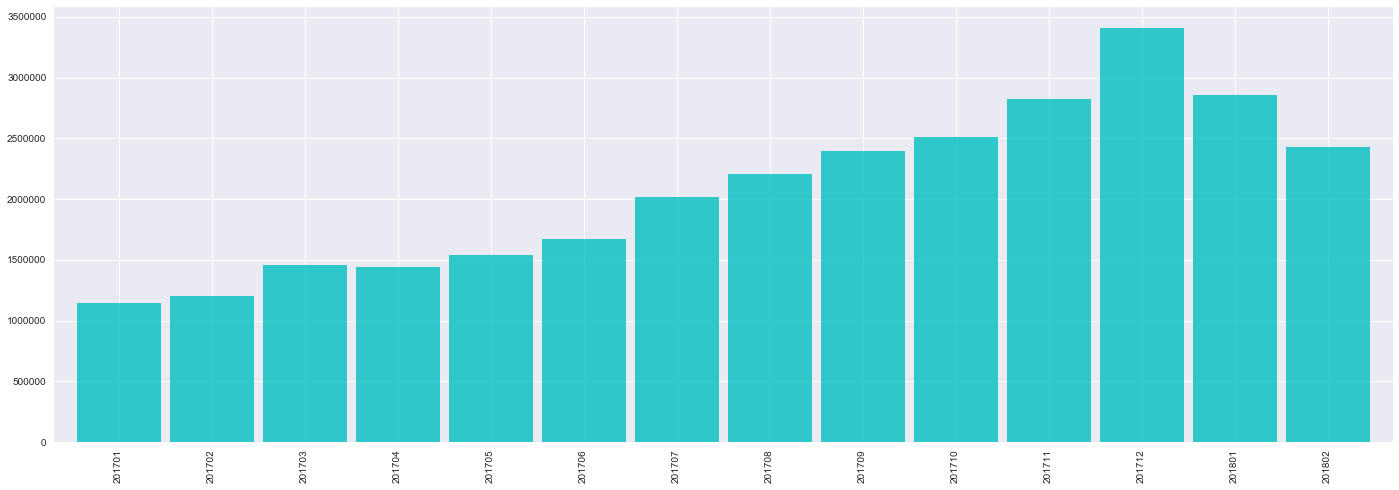

In [8]:
historical_transactions["purchase_month"] = historical_transactions.purchase_date.dt.year * 100 + historical_transactions.purchase_date.dt.month
historical_transactions.purchase_month.value_counts().sort_index().plot(kind="bar", figsize=(24, 8), color="c", width=.9, alpha=.8)

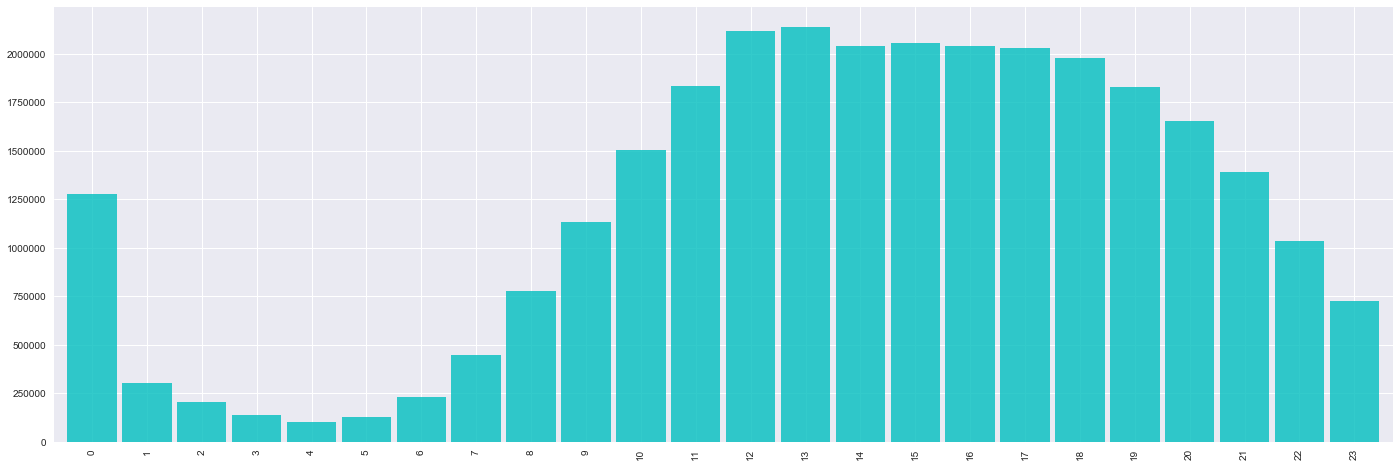

In [13]:
historical_transactions.purchase_date.dt.hour.value_counts().sort_index().plot(kind="bar", figsize=(24, 8), color="c", width=.9, alpha=.8)

In [15]:
historical_transactions.describe().T.apply(lambda x: round(x, 2))

,count,mean,std,min,25%,50%,75%,max
city_id,29112361.0,129.33,104.26,-1.00,53.00,90.00,212.0,347.00
installments,29112361.0,0.65,2.80,-1.00,0.00,0.00,1.0,999.00
merchant_category_id,29112361.0,481.01,249.38,-1.00,307.00,454.00,705.0,891.00
month_lag,29112361.0,-4.49,3.59,-13.00,-7.00,-4.00,-2.0,0.00
purchase_amount,29112361.0,0.04,1123.52,-0.75,-0.72,-0.69,-0.6,6010603.97
category_2,26459497.0,2.19,1.53,1.00,1.00,1.00,3.0,5.00
state_id,29112361.0,10.57,6.37,-1.00,9.00,9.00,16.0,24.00
subsector_id,29112361.0,26.85,9.69,-1.00,19.00,29.00,34.0,41.00
purchase_month,29112361.0,201724.66,36.29,201701.00,201706.00,201709.00,201712.0,201802.00


In [16]:
del historical_transactions
gc.collect()

130

In [17]:
new_merchant_transactions = pd.read_csv("./data/new_merchant_transactions.csv")
print("historical_transactions.shape", new_merchant_transactions.shape)
print("head")
print(new_merchant_transactions.head())
print("describe")
new_merchant_transactions["purchase_date"] = pd.to_datetime(new_merchant_transactions.purchase_date)
print(new_merchant_transactions.purchase_date.describe())

historical_transactions.shape (1963031, 14)
head
  authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_415bb3a509      107          N             1   
1               Y  C_ID_415bb3a509      140          N             1   
2               Y  C_ID_415bb3a509      330          N             1   
3               Y  C_ID_415bb3a509       -1          Y             1   
4               Y  C_ID_ef55cf8d4b       -1          Y             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   307  M_ID_b0c793002c          1   
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount        purchase_date  category_2  state_id  subsector_id  
0        -0.557574  2018-03-11 14:57:36    

In [18]:
new_merchant_transactions.card_id.nunique()

290001

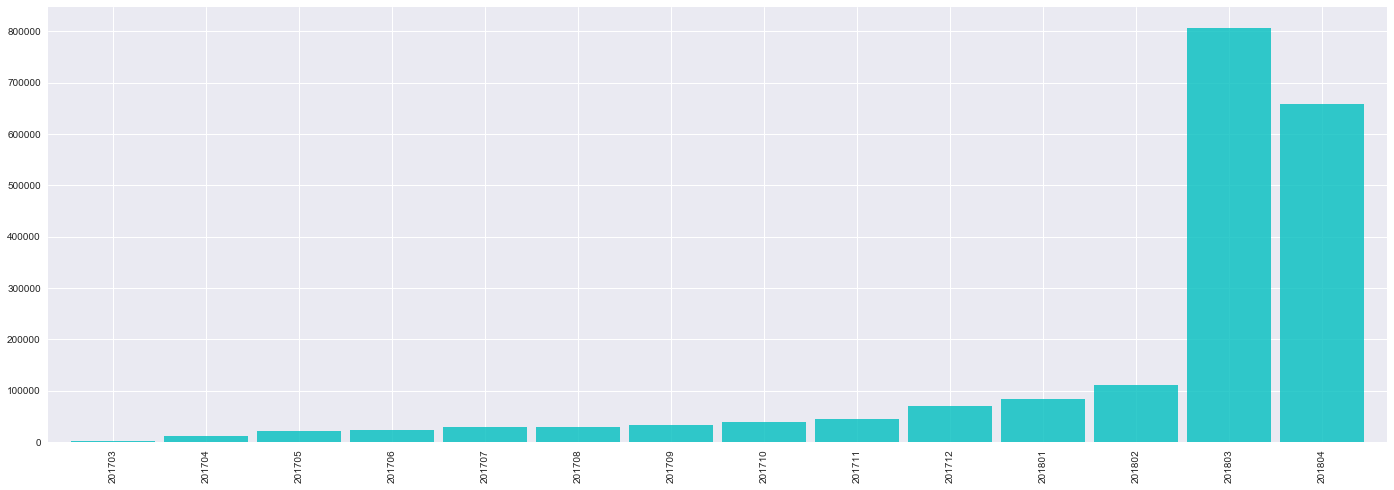

In [19]:
new_merchant_transactions["purchase_month"] = new_merchant_transactions.purchase_date.dt.year * 100 + new_merchant_transactions.purchase_date.dt.month
new_merchant_transactions.purchase_month.value_counts().sort_index().plot(kind="bar", figsize=(24, 8), color="c", width=.9, alpha=.8)

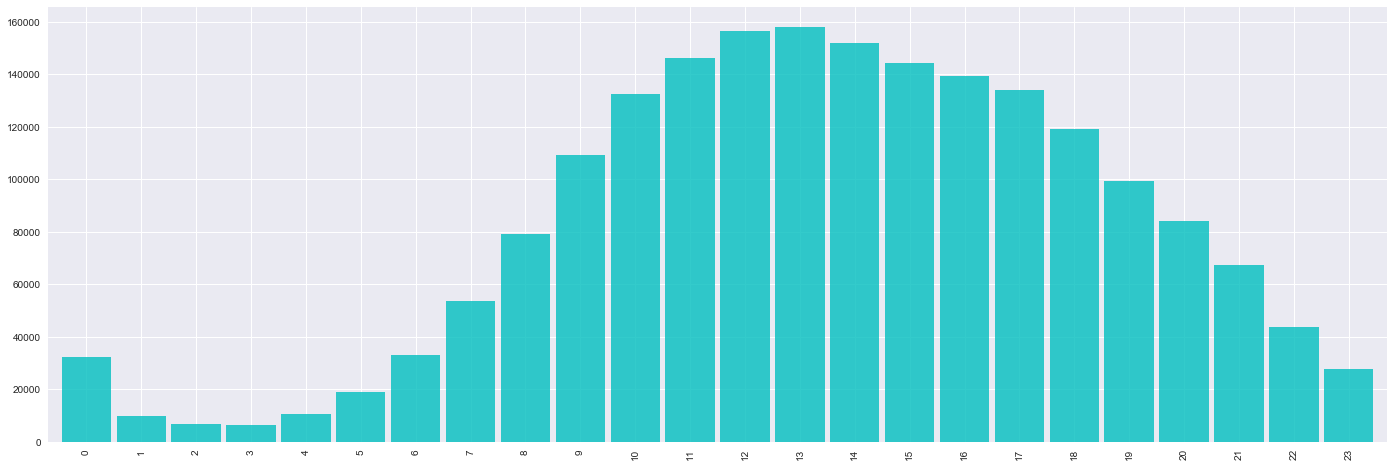

In [20]:
new_merchant_transactions.purchase_date.dt.hour.value_counts().sort_index().plot(kind="bar", figsize=(24, 8), color="c", width=.9, alpha=.8)

In [21]:
new_merchant_transactions.describe().T.apply(lambda x: round(x, 2))

,count,mean,std,min,25%,50%,75%,max
city_id,1963031.0,134.39,101.52,-1.00,69.00,110.00,212.00,347.00
installments,1963031.0,0.68,1.58,-1.00,0.00,1.00,1.00,999.00
merchant_category_id,1963031.0,430.97,246.34,-1.00,278.00,367.00,683.00,891.00
month_lag,1963031.0,1.48,0.50,1.00,1.00,1.00,2.00,2.00
purchase_amount,1963031.0,-0.55,0.69,-0.75,-0.72,-0.67,-0.58,263.16
category_2,1851286.0,2.20,1.53,1.00,1.00,1.00,3.00,5.00
state_id,1963031.0,10.88,6.04,-1.00,9.00,9.00,15.00,24.00
subsector_id,1963031.0,25.98,10.13,-1.00,19.00,29.00,34.00,41.00
purchase_month,1963031.0,201788.68,34.05,201703.00,201802.00,201803.00,201804.00,201804.00


In [22]:
del new_merchant_transactions
gc.collect()

452

# merchants

In [24]:
merchants = pd.read_csv("./data/merchants.csv")
print("merchants.shape", merchants.shape)
print("head")
merchants.head()

merchants.shape (334696, 22)
head


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [26]:
print(merchants.merchant_id.nunique())
print(merchants.merchant_group_id.nunique())
print(merchants.merchant_category_id.nunique())

334633
109391
324
